# Import libraries
 

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import ufl
import basix 
import extract

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType
import sys
from meshes import generate_PacMan
from petsc_solvers import SNESSolver
from utils import ColorPrint

petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-09,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}
        
def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    # fem_func.x.scatter_forward()


# Interpolate an expression on an element
def interpolate_quadrature_on_element(expr, function_space:fem.FunctionSpace, mesh, cell_number):
    assert function_space.family() == 'Quadrature'
    
    q_dim = function_space.degree()
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, _ = basix.make_quadrature(basix_celltype, q_dim)

    expr_expr = fem.Expression(expr, quadrature_points)
    expr_eval = expr_expr.eval(cell_number)
    return expr_eval


# Define the mesh

In [2]:
R = 10.
ouverture = np.pi/6*0.01
omega = np.pi-ouverture/2
lc =0.5
refinement_ratio = 10
dist_min = .1
dist_max = .3

msh, cell_tags, facet_tags = generate_PacMan(
        R=R,
        theta=ouverture,
        lc=lc,  # caracteristic length of the mesh
        refinement_ratio=refinement_ratio,  # how much it is refined at the tip zone
        dist_min=dist_min,  # radius of tip zone
        dist_max=dist_max,  # radius of the transition zone
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Ellipse)
Info    : Done meshing 1D (Wall 0.0038438s, CPU 0.003924s)
Info    : Meshing 2D...
Info    : Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0718942s, CPU 0.071924s)
Info    : 2360 nodes 4722 elements


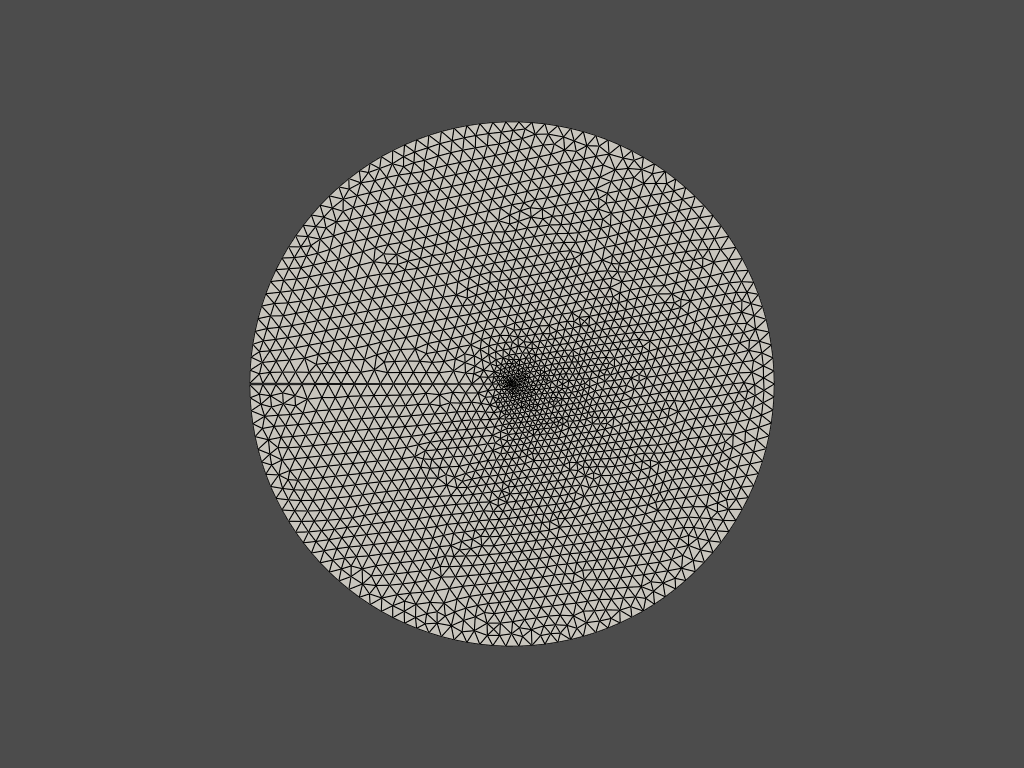

In [3]:
import pyvista
pyvista.start_xvfb()
pyvista.set_jupyter_backend("none")
grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(msh))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    plotter.show()

In [4]:
# Save the mesh in XDMF format
with io.XDMFFile(MPI.COMM_WORLD, "output/PacMan_V1.xdmf", "w") as file:
    file.write_mesh(msh)
    msh.topology.create_connectivity(1, 2)
    file.write_meshtags(cell_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")
    file.write_meshtags(facet_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")

    # this way we can verify that we correctly assigned facet tags (plot "PacMan_facets" in paraview with readerT)

# Finite element function space

We use here linear Lagrange triangle elements

In [5]:
deg_stress = 0
deg_u = 1

element = ufl.FiniteElement('Lagrange',msh.ufl_cell(),degree=deg_u)
V = fem.FunctionSpace(msh, element)

element_stress = ufl.VectorElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')
element_stress_scalar = ufl.FiniteElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')

V_stress = fem.FunctionSpace(msh, element_stress)
V_stress_scalar = fem.FunctionSpace(msh, element_stress_scalar)

# Boundary conditions

In [7]:
sig00 = 1.
mu0 = 1.
R_ecr0 = 0.01

ring_facets = facet_tags.find(1)
top_lip_facets = facet_tags.find(3)
bottom_lip_facets = facet_tags.find(2)
# visualize in paraview if doubt

ring_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, ring_facets)

top_lip_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, top_lip_facets)

bottom_lip_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, bottom_lip_facets)

'''
On met en chargement la solution élastique trouvée analytiquement. 
Ce déplacement est appliqué sur le bord de notre PacMan, on pourra 
laisser libres dans un premier temps les lèvres, cela ne devrait 
pas changer grand chose.
Il faudra donc veiller en observant les résultats que la plasticité n'atteint pas les bords du PacMan
'''
def boundary_D(x):
    x0, y0 = x[0], x[1]
    r = np.sqrt(x0**2+y0**2)
    return np.isclose(r, R)

dofs_D = fem.locate_dofs_geometrical(V, boundary_D)
# ---- à refaire à chaque pas de temps en changeant le t

t = 1.
def u_exact(x):
    x0, y0 = x[0], x[1]
    r = np.sqrt(x0**2+y0**2)
    theta = np.arctan2(y0, x0)
    alpha = np.pi/(2*omega)
    return 2*t/(mu0*np.sqrt(2*np.pi))*r**alpha*np.sin(alpha*theta) # K_iii = t


#dofs_D = ring_dofs      # cela ne fonctionne pas.... bizzarre, la difference est surement que l'un est un objet topologique et l'autre géométrique
u_bc = fem.Function(V)
u_bc.interpolate(u_exact)
bc = fem.dirichletbc(u_bc, dofs_D)
bcs = [bc]
# ----


dx = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"} )
ds = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags)
n = ufl.FacetNormal(msh)

# Form functions

In [8]:



mu = fem.Constant(msh,mu0) # PETSc.ScalarType(1.)

def eps(u):
    """Strain"""
    return ufl.grad(u)  

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = fem.Constant(msh,ScalarType(0))

    # Surface force on the top 
    f = fem.Constant(msh,ScalarType(0.))
    return b * v * dx + f * v * ds(1)

def norm_s(sig):
    return ufl.sqrt(3*ufl.inner(sig, sig))

def sig_new(sigma_elas, sig_old, sig_0, p_old, R_ecr):  
    criterion = norm_s(sigma_elas)-sig_0-R_ecr*p_old
    direction = sigma_old/(norm_s(sigma_old))   
    return ufl.conditional(criterion > 0., sigma_elas - 3*mu/(R_ecr+3*mu)*criterion*direction, sigma_elas)

def dp(sigma_elas, mu, sig_0, p_old, R_ecr):
    criterion = norm_s(sigma_elas)-sig_0-R_ecr*p_old
    return ufl.conditional(criterion > 0., criterion/(R_ecr+3.*mu), fem.Constant(msh,0.)) # PETSc.ScalarType(0.)

def deps_p(sigma_elas, sigma, mu):
    criterion = sigma_elas-sigma 
    test = norm_s(criterion)
    return ufl.conditional( test > 0., criterion/mu, ufl.as_vector([0.,0.]))


# State the problem 

In [9]:
u = fem.Function(V,name="u")
u_old = fem.Function(V)
v = ufl.TestFunction(V)

sig_0 = sig00
R_ecr = R_ecr0
eps_p = fem.Function(V_stress,name="epsp")
eps_p_old = fem.Function(V_stress)
p = fem.Function(V_stress_scalar,name="p")
p_old = fem.Function(V_stress_scalar)
sigma = fem.Function(V_stress,name="stress")
sigma_old = fem.Function(V_stress)

sigma_elas = sigma_old+mu*eps(u-u_old)
sigma_new = sig_new(sigma_elas, sigma_old, sig_0, p_old, R_ecr)

residual = ufl.inner(sigma_new, eps(v)) * dx - L(v)
my_problem = SNESSolver(residual, u, bcs=bcs, petsc_options=petsc_options_SNES)

stress_expr = fem.Expression(sigma_new, V_stress.element.interpolation_points())
stress_elas_expr = fem.Expression(sigma_elas, V_stress.element.interpolation_points())

p_expr = fem.Expression(p_old+dp(sigma_elas, mu, sig_0, p_old, R_ecr), V_stress_scalar.element.interpolation_points())
eps_p_expr = fem.Expression(eps_p_old+deps_p(sigma_elas, sigma_new, mu), V_stress.element.interpolation_points())


# Solve the problem

In [10]:
with io.XDMFFile(MPI.COMM_WORLD, "output/PacMan_res.xdmf", "w") as file:
    file.write_mesh(msh) # u.function_space.mesh
    msh.topology.create_connectivity(1, 2)
    file.write_meshtags(cell_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")
    file.write_meshtags(facet_tags, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry")
t_max = 1.5
loads = np.linspace(0,t_max,40)
plastic_dissipations = np.zeros_like(loads)
Fs = []


for i,t in enumerate(loads):
    u_old.x.array[:] = u.x.array
    p_old.x.array[:] = p.x.array
    eps_p_old.x.array[:] = eps_p.x.array
    sigma_old.x.array[:] = sigma.x.array
    
    # Update boundary condition    
    def u_exact(x):
        x0, y0 = x[0], x[1]
        r = np.sqrt(x0**2+y0**2)
        theta = np.arctan2(y0, x0)
        alpha = np.pi/(2*omega)
        return 2*t/(mu0*np.sqrt(2*np.pi))*r**alpha*np.sin(alpha*theta) # K_iii = t   
    u_bc.interpolate(u_exact)
    u_bc.x.scatter_forward()
    
    # Solve
    ColorPrint.print_info(f"Solve for t={t:5.3f}")
    out = my_problem.solve()
    ColorPrint.print_info(out)
    
    # update 
    eps_p.interpolate(eps_p_expr)
    eps_p.x.scatter_forward()    
    p.interpolate(p_expr)
    p.x.scatter_forward()
    sigma.interpolate(stress_expr)
    sigma.x.scatter_forward()
    plastic_dissipations[i] = fem.assemble_scalar(fem.form(sig_0 * p * dx))
    
    # calcul des forces sur les bords
    #force = fem.assemble_scalar(fem.form(ufl.dot(sigma, n)*ds(1))) # 1 : disk
    
    tol = 1e-2
    fx = extract.solution(msh, sigma, -(R-tol)*np.cos(omega), (R-tol)*np.sin(omega))[0]
    fy = extract.solution(msh, sigma, -(R-tol)*np.cos(omega), (R-tol)*np.sin(omega))[1]
    force = np.sqrt(fx**2+fy**2)
    Fs.append(force)
    
    
    with io.XDMFFile(MPI.COMM_WORLD, "output/PacMan_res.xdmf", "a") as file:
        #file.write_mesh(u.function_space.mesh)
        file.write_function(u,t)
        file.write_function(eps_p,t)
        file.write_function(p,t)
        file.write_function(sigma,t)

Solve for t=0.000
  0 SNES Function norm 0.000000000000e+00 
(0, 2)
Solve for t=0.038
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 1.412913903557e-15 
(1, 2)
Solve for t=0.077
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 1.758627201746e-15 
(1, 2)
Solve for t=0.115
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 1.888717081301e-15 
(1, 2)
Solve for t=0.154
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 2.196148859298e-15 
(1, 2)
Solve for t=0.192
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 1.918432428633e-03 
  2 SNES Function norm 3.855141510942e-04 
  3 SNES Function norm 1.685507944650e-07 
  4 SNES Function norm 6.155265880189e-15 
(4, 2)
Solve for t=0.231
  0 SNES Function norm 1.237756968643e+00 
  1 SNES Function norm 1.274125930478e-03 
  2 SNES Function norm 5.423105823442e-07 
  3 SNES Function norm 1.114583321193e-13 
(3, 2)
Solve for t=0.269
  0 SNES Function norm 1.23775696

### Commentaries





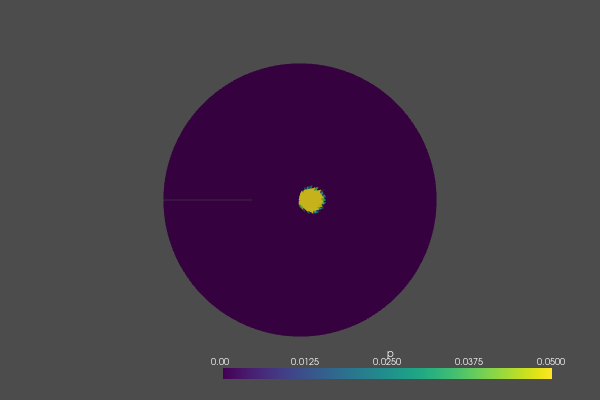

In [11]:
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
topology, cell_types, geometry = plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.cell_data["p"] = p.x.array.real
u_grid.set_active_scalars("p")
u_plotter = pyvista.Plotter(window_size=(600, 400))
u_plotter.add_mesh(u_grid, show_edges=False,clim=[0,0.05])
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [12]:
import numpy as np
import extract
import scipy.optimize as op

n_points = 30
tol=1e-2

theta = np.pi/6*2

list_r = np.linspace(0,R-tol, n_points)
list_u = np.zeros(n_points)
list_p = np.zeros(n_points)
list_eps_p_yy = np.zeros(n_points)
list_sigma_yy = np.zeros(n_points)

for i,r in enumerate(list_r):
    x0, y0 = r*np.cos(theta), r*np.sin(theta)
    list_u[i] = extract.solution(msh, u, x0, y0)[0]
    list_p[i] = extract.solution(msh, p, x0, y0)[0]
    list_eps_p_yy[i] = extract.solution(msh, eps_p, x0, y0)[1]
    list_sigma_yy[i] = extract.solution(msh, sigma, x0, y0)[1]
    
list_u_analytic = np.zeros(n_points)
list_sigma_analytic = np.zeros(n_points)

K_iii = t_max
tau_y = sig00/np.sqrt(3)
r_p = 1/(2*np.pi)*(K_iii/tau_y)**2
print("r_p = ", r_p)



for i,r in enumerate(list_r):
    theta1 = 2*theta
    r1 = r*np.sin(theta)/np.sin(theta1)
    
    if r1>=r_p : # zone élastique
        print("r1 = ",r1)
        list_u_analytic[i] = K_iii/mu0*np.sqrt(2*r1/np.pi)*np.cos(theta)
        list_sigma_analytic[i] = K_iii/np.sqrt(2*r1*np.pi)*np.sin(theta)
        
    else : # zone plastique
        list_u_analytic[i] = tau_y/(np.pi*mu0)*(K_iii/tau_y)**2*np.sin(theta)
        list_sigma_analytic[i] = tau_y*np.cos(theta)
        
        
        


r_p =  1.0742958658702932
r1 =  1.3779310344827584
r1 =  1.722413793103448
r1 =  2.066896551724138
r1 =  2.4113793103448278
r1 =  2.755862068965517
r1 =  3.100344827586207
r1 =  3.444827586206896
r1 =  3.789310344827586
r1 =  4.133793103448276
r1 =  4.478275862068965
r1 =  4.8227586206896556
r1 =  5.167241379310345
r1 =  5.511724137931034
r1 =  5.856206896551724
r1 =  6.200689655172414
r1 =  6.545172413793103
r1 =  6.889655172413792
r1 =  7.234137931034482
r1 =  7.578620689655172
r1 =  7.923103448275861
r1 =  8.267586206896553
r1 =  8.61206896551724
r1 =  8.95655172413793
r1 =  9.301034482758618
r1 =  9.645517241379311
r1 =  9.989999999999998


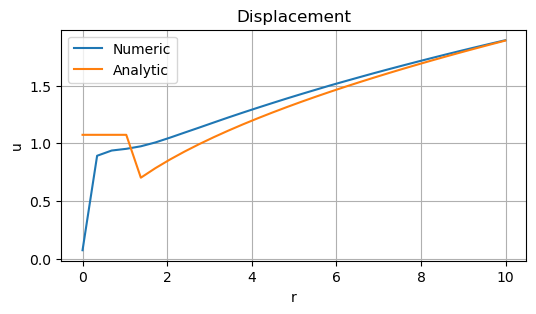

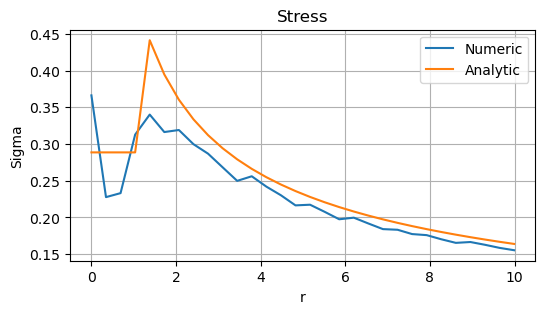

In [13]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_u, label = 'Numeric')
plt.plot(list_r, list_u_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('u')
plt.title('Displacement')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_u2')

fig=plt.figure(figsize=(6, 3))
plt.plot(list_r, list_sigma_yy, label = 'Numeric')
plt.plot(list_r, list_sigma_analytic, label = 'Analytic')
plt.xlabel('r')
plt.ylabel('Sigma')
plt.title('Stress')
plt.legend()
plt.grid()
plt.show()
fig.tight_layout()
fig.savefig('comp_sig2')